Kaggle Competition: Zillow Home Valuation Prediction
----------------------------------------------------

I'm going to use XGBoost to fit a boosted tree ensemble to the data from the [Zillow Kaggle Competition](https://www.kaggle.com/c/zillow-prize-1). The quantity to predict is the size of the error that Zillow's own algorithm has made in predicting housing prices, based on a large number of variables describing the house. Since we're trying to capture the errors in model that's already being used, it will probably be difficult to make any headway, but that's why it's a competition.

First we will load the required libraries, load in the data, and preprocess the data.

In [4]:
import warnings; warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
# Competition training data
known = pd.read_csv('input/train_2016_v2.csv')

# Full set of properties
population = pd.read_csv('input/properties_2016.csv')

# Properties for which to predict in order to 
unknown = pd.read_csv('input/sample_submission.csv')

In [3]:
# Some variables are categorical, and we will split them up using OneHot encoding
categorical_cols = [
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingclasstypeid',
    'decktypeid',
    'fips',
    'fireplaceflag',
    'hashottuborspa',
    'heatingorsystemtypeid',
    'storytypeid',
    'typeconstructiontypeid',
    'taxdelinquencyflag',
]

# Some variables take on very many categorical values. For the sake of this exercise, we'll drop them.
cols_to_drop = [
    'rawcensustractandblock',
    'censustractandblock',
    'propertycountylandusecode',
    'propertylandusetypeid',
    'propertyzoningdesc',
    'regionidcounty',
    'regionidcity',
    'regionidzip',
    'regionidneighborhood',
    'taxdelinquencyyear'
]

# Creating our full dataset
df_known = known.merge(population, how='left', on='parcelid')

# Dropping selected columns
df_known = df_known.drop(cols_to_drop, axis=1)

# Re-encoding categorical variables
df_known_cat = pd.get_dummies(df_known, columns=categorical_cols)

# Transforming the transaction date into an ordinal variable: number of days since 01-01-2015
df_known_cat['transactiondate_ordinal'] = pd.to_datetime(df_known_cat['transactiondate'],infer_datetime_format=True) - datetime.date(2015,1,1)
df_known_cat['transactiondate_ordinal'] = df_known_cat['transactiondate_ordinal'].dt.days
df_known_cat = df_known_cat.drop('transactiondate', axis=1)

# Creating our variables and targets
X = df_known_cat.drop(["logerror", "parcelid"], axis=1)
y = df_known_cat["logerror"]

# Randomly splitting into a training and a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

We are now ready for our first attempt at training.

In [4]:
# Setting up initial parameters for our model, with arbitrary guesses for the numerical parameters.
xgb_params = {
    "objective": "reg:linear", 
    "max_depth": 6, 
    "silent": 0, 
    'eval_metric': 'mae', 
    'eta': 0.01
}

# Maximum number of trees we will collect
num_rounds = 1000

# Transforming our data into XGBoost's internal DMatrix structure
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

# Training
model = xgb.train(
    xgb_params,                           # Training parameters
    dtrain,                               # Data
    num_rounds,                           # Max number of trees
    [(dtrain,'train'),(dvalid,'test')],   # Validation set
    early_stopping_rounds=50,            # Stop early if no improvement for 100 rounds
    verbose_eval = False
)

# Best score obtained
print(model.best_score)

0.068397


Improving the model
-------------------

The score above is already pretty decent. At the time of writing, the scores in the Kaggle competition range from around 0.068 to around 0.064. With the model above we are already at the low end. The small range of scores compared to this base score is an indication of how hard this particular problem is.

Let us try to improve upon our score. For this exercise, we will not optimize all the hyperparameters of the model, but we will optimize a few. We will use a grid search, using cross validation to assess the performance of the model. In order to be able to run this (computationally expensive) search, this optimization is actually done in two separate Python scripts: `CV_eta.py` and `CV_maxdepth_minchildweight.py`.

As indicated by the names, the first script optimizes `eta`, or the learning rate, and the second simulateneously optimizeds `max_depth` (the maximum tree depth) and `min_child_weight`, which in this case places a lower bound on the number of data points on each side of a split in the tree.

Looking for the optimal learning rate produces the following plot.

![](img/eta.png)

In order to accommodate slower learning, we increased the number of trees for this optimization. We see that, in that case, slower learning performs better, pushing the optimal `eta` down to 0.005. However, the validation error remains at 0.68, so as long as the use the right number of trees, our original rate was fine.

Considering `max_depth` and `min_child_weight`, we find the following results.

![](img/cv2.png)

We see that there is no benefit to increasing `min_child_weight` to more than 1. The corresponding curve for `max_depth` is fairly flat: the model is not very sensitive to this value, so we don't expect a big performance boost from tuning it. To avoid overfitting, we will go to smaller depths.

In [5]:
# We slightly speed up learning for convenience, and decrease the tree depth
xgb_params = {
    "objective": "reg:linear", 
    "max_depth": 3, 
    "silent": 0, 
    'eval_metric': 'mae', 
    'eta': 0.02
}

# Maximum number of trees we will collect
num_rounds = 1000

# Transforming our data into XGBoost's internal DMatrix structure
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

# Training
model = xgb.train(
    xgb_params,                           # Training parameters
    dtrain,                               # Data
    num_rounds,                           # Max number of trees
    [(dtrain,'train'),(dvalid,'test')],   # Validation set
    early_stopping_rounds=50,             # Stop early if no improvement for 50 rounds
    verbose_eval = False
)

# Best score obtained
print(model.best_score)

0.068047


We could tune further hyperparameters, but the limiting factor here is likely the data itself, judging from the range of scores on the leaderboard, and we should not expect much of a performance boost from tuning. We will therefore leave the parameters for what they are for now, and move on to a different potential improvement.

Cutting out outliers
--------------------

The dataset contains a large number of outliers, including some very large/small ones: 

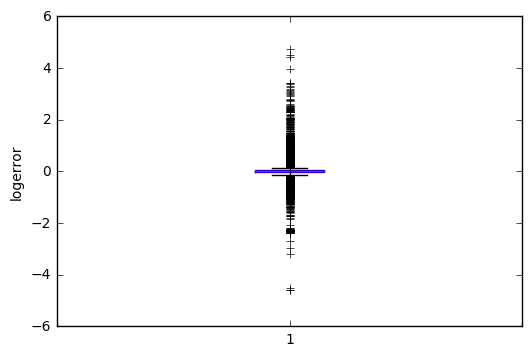

In [3]:
plt.boxplot(known['logerror'])
plt.ylabel('logerror')
plt.show()

Apparently there are houses in the dataset for which Zillow's algorithm made large errors. Normally one might think that the outliers are the most interesting to look at, because that's where there is a lot of room for improvement. However, for our current purposes this may not be the case, because

1) the error may be large simply because the price of the house is high;

2) for high-value houses, not much data is available, so we may not be able to learn much;

3) the market for high-value houses is small, so that prices are dependent on the tastes and funds of available buyers, leading to unpredictable variance.

Of course the above may or may not be the real underlying reason for the outliers, but it suggests that it may be worth trying to remove the outliers from the training set, because they may not contain much generalizable information.

In [4]:
# Quick function to find outliers. A data point in a series is considered
# an outlier if it is more than the inter-quartile range (IQR), multiplied
# by some factor, away from the first or third quartile.
def getIQROutlierBool(series, factor):
    q1 = series.quantile(0.25) # First quartile
    q3 = series.quantile(0.75) # Third quartile
    
    # Generate a boolean series indicating whether or not the data point is
    # within the specified range
    iqr = (series > q1-factor*(q3-q1)) & (series < q3+factor*(q3-q1))
    return iqr

# Apply the filter to our logerror values
outlier_filter = getIQROutlierBool(y_train, 1.5)

# Cut out the outliers from the training set
X_train = X_train[outlier_filter]
y_train = y_train[outlier_filter]

Above, we have filtered out the outliers from the training set (not from the validation set) by removing all data points that are too far away from the first and third quartiles. If a value is smaller than the first quartile, or larger than the third quartile, by at least 1.5 times the interquartile range (distance between first and third quartiles), we discard it. The factor 1.5 is the standard value, but some manual checks indicate that the result is not strongly dependent on the choice.

In [5]:
# We keep the parameters
xgb_params = {
    "objective": "reg:linear", 
    "max_depth": 3, 
    "silent": 0, 
    'eval_metric': 'mae', 
    'eta': 0.02
}

# Maximum number of trees we will collect
num_rounds = 5000

# Our X_train and y_train have now been cleaned of outliers
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

# Training
model = xgb.train(
    xgb_params,                           # Training parameters
    dtrain,                               # Data
    num_rounds,                           # Max number of trees
    [(dtrain,'train'),(dvalid,'test')],   # Validation set
    early_stopping_rounds=50,             # Stop early if no improvement for 50 rounds
    verbose_eval = False
)

# Best score obtained
print(model.best_score)
print(model.best_iteration)

# Save the model
model.save_model('xgb_outliersremoved.model')

0.067132
1136


We see that removing the outliers from the training set has improved the score a little bit. We are not yet near the top of the leaderboard (0.064) but we've nudged away from the bottom.

(Note that here we are just validating on the test set. The model is saved above, to be used in `predict.py` to generate a submission file for the competition.)

Conclusions
-----------

The Zillow dataset is difficult. We have a predictive model that works, in a sense, but not very well, considering the following plot.

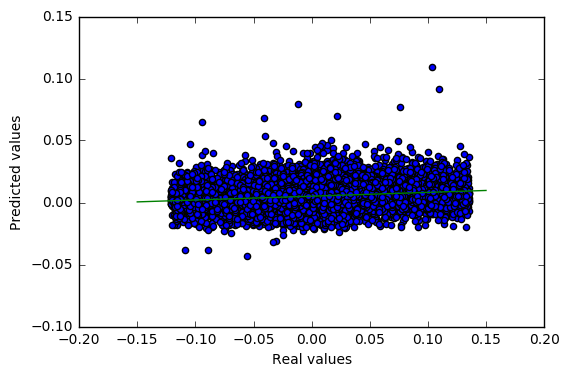

In [9]:
# Cut out the outliers from the test set for plotting
outlier_filter = getIQROutlierBool(y_test, 1.5)
X_test = X_test[outlier_filter]
y_test = y_test[outlier_filter]
dtest = xgb.DMatrix(X_test)

# Predict with our model
y_pred = model.predict(dtest)
plt.scatter(y_test, y_pred)
plt.xlabel('Real values')
plt.ylabel('Predicted values')

# Add a trend line
regression = np.polyfit(y_test, y_pred, 1)
x_vals = np.array([-0.15, 0.15])
y_vals = regression[0]*x_vals + regression[1]
plt.plot(x_vals, y_vals, color='green')

plt.show()

The figure above plots the `logerror` values we predict for the validation set versus the true values, as well as a trend line. We see that we have some correlation, but the slope is certainly not close to 45 degrees, and the spread of the points is very large. Our score of 0.67 does not indicate a very strong grasp on the problem, and likely neither do the top scores on the Kaggle leaderboard of around 0.64.

Tuning the hyperparameters apparently helps little. Solving this problem requires something new altogether; either a different kind of model is required, or some novel insight into the data. Cutting out the outliers in the training set helps somewhat, but only so much. It will be interesting to see if anyone can find a way forward.